In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
from os.path import expanduser
## actions required!!!!!!!!!!!!!!!!!!!! change your folder path 
path_repo = expanduser("~/Documents/G3_2/regime-identification"); sys.path.append(path_repo)
path_file = expanduser("~/data/G3_2/regime-identification/simulation")
path = {}
path["data"] = f"{path_repo}/data"
for folder in ["figure-paper"]:
    path[folder] = f"{path_file}/{folder}"

In [2]:
import numpy as np
import pandas as pd

from numpy.random import RandomState
from datetime import date

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mpl.style.use("seaborn-v0_8")
plt.rcParams['figure.figsize'] = [9, 9]
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['font.size'] = 30
plt.rcParams['font.family'] = 'cmr10'
plt.rcParams['axes.formatter.use_mathtext'] = True

In [3]:
from regime.mkt_calendar import *
from regime.stats import *
from regime.jump import *
from regime.simulation_helper import *

In [4]:
df = pd.read_hdf(f"{path['data']}/NASDAQ_ret.h5")

# sub period 2: 2013-2022

In [5]:
start, end = date(2013, 1, 1), date(2022, 12, 31)
df_sub = df.loc[get_trading_day_offset(start, -20):end]
X = df_sub[['CCMP_ret_log']].to_numpy()
X_zhengB = pd.DataFrame(feature_engineer_zheng(X), index=df_sub.index)[start:]
X_zhengB_np = X_zhengB.to_numpy()
df_sub = df_sub[start:]
X_zhengB

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2013-01-02,0.030255,0.010454,0.028411,0.004960,0.016122,-0.003896,0.003176,0.013815,0.020112,0.002095,0.012358,0.001322,0.009071,0.002869,0.015723
2013-01-03,-0.003763,0.034018,0.010454,0.004797,0.016221,-0.005837,0.003865,0.015431,0.017425,0.002027,0.012390,0.000341,0.009924,0.003714,0.015082
2013-01-04,0.000351,0.004115,0.034018,0.006102,0.015326,0.003256,0.014772,0.008948,0.018567,0.002567,0.012118,0.000973,0.009495,0.004162,0.014902
2013-01-07,-0.000919,0.001271,0.004115,0.006186,0.015278,0.013815,0.020112,-0.001444,0.002107,0.003001,0.011856,0.000902,0.009565,0.005099,0.014240
2013-01-08,-0.002261,0.001342,0.001271,0.007244,0.014232,0.015431,0.017425,-0.000943,0.001307,0.001901,0.011554,-0.001176,0.007901,0.004979,0.014308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.002073,0.024094,0.037288,-0.004892,0.013411,-0.008223,0.007669,-0.001560,0.018908,-0.004879,0.014447,-0.000880,0.012403,-0.008877,0.016157
2022-12-27,-0.013873,0.015946,0.024094,-0.005575,0.013808,0.000123,0.015133,-0.011274,0.012255,-0.004425,0.014021,-0.002675,0.016044,-0.006175,0.012704
2022-12-28,-0.013609,0.000264,0.015946,-0.005343,0.013628,-0.002217,0.018752,-0.008470,0.009131,-0.005031,0.014235,-0.003339,0.016257,-0.006723,0.012965
2022-12-29,0.025597,0.039205,0.000264,-0.001094,0.018697,-0.001560,0.018908,-0.000628,0.022712,-0.004003,0.015918,-0.007082,0.015342,-0.000923,0.017074


In [6]:
def fit_and_print_model(model, X):
    model.fit(X)
    if hasattr(model, "proba_"):
        proba = model.proba_
    else:
        proba = raise_labels_to_proba_(model.labels_, model.n_components)
    means, covars = weighted_mean_vol(X[:, 0], proba)
    transmat = empirical_trans_mx(proba.argmax(axis=1))
    print(f"means: {means}")
    print(f"stds: {np.sqrt(covars)}")
    return means, np.sqrt(covars), transmat.flatten()[[1, 2]]

In [7]:
def cast_into_ser(x):
    means, stds, trans = x
    means = pd.Series(means, index=["$\\mu_" + f"{i}$" for i in range(len(means))])
    stds = pd.Series(stds, index=["$\\sigma_" + f"{i}$" for i in range(len(stds))])
    trans = pd.Series(trans, index=["$\\gamma_{01}$", "$\\gamma_{10}$"])
    return pd.concat([means, stds, trans])

In [8]:
model, results = {}, {}

In [9]:
random_state = RandomState(10)
name = "discrete"
# discrete
model[name] = jump_model(2, state_type="discrete", jump_penalty=100.0, n_init=10, random_state=random_state)
x = fit_and_print_model(model[name], X_zhengB_np)
results[name] = cast_into_ser(x)
# empirical_trans_mx(model_discrete.labels_)

means: [ 0.00082894 -0.00133565]
stds: [0.00982824 0.0238848 ]


In [10]:
# cont
name = "cont"
model[name] = jump_model(2, state_type="cont", jump_penalty=1000, grid_size=.02, mode_loss=False, n_init=10, random_state=random_state)
x = fit_and_print_model(model[name], X_zhengB_np)
results[name] = cast_into_ser(x)

means: [ 0.00090305 -0.00138282]
stds: [0.00953078 0.02306456]


In [11]:
# cont w/ mode loss
name = "$\\text{cont}_{\\text{M}}$"
model[name] = jump_model(2, state_type="cont", jump_penalty=1000, grid_size=.02, mode_loss=True, n_init=10, random_state=random_state)
x = fit_and_print_model(model[name], X_zhengB_np)
results[name] = cast_into_ser(x)

means: [ 0.0008682  -0.00138596]
stds: [0.00968573 0.0234898 ]


In [12]:
results_df = pd.DataFrame(results).T
results_df = results_df.applymap(lambda x: f"{100*x:.4f}\\%")
results_df

,$\mu_0$,$\mu_1$,$\sigma_0$,$\sigma_1$,$\gamma_{01}$,$\gamma_{10}$
discrete,0.0829\%,-0.1336\%,0.9828\%,2.3885\%,0.1410\%,0.5141\%
cont,0.0903\%,-0.1383\%,0.9531\%,2.3065\%,0.2874\%,1.1655\%
$\text{cont}_{\text{M}}$,0.0868\%,-0.1386\%,0.9686\%,2.3490\%,0.1879\%,0.7732\%


In [26]:
print(results_df.style.to_latex(hrules=True, label="tab: parameters 2013", caption="2013-2022", position_float="centering", position="htbp"))

\begin{table}[htbp]
\centering
\caption{2013-2022}
\label{tab: parameters 2013}
\begin{tabular}{lllllll}
\toprule
 & $\mu_0$ & $\mu_1$ & $\sigma_0$ & $\sigma_1$ & $\gamma_{01}$ & $\gamma_{10}$ \\
\midrule
discrete & 0.1148\% & -0.1528\% & 1.2160\% & 2.6879\% & 0.1167\% & 0.2488\% \\
cont & 0.1029\% & -0.1879\% & 1.2891\% & 2.8616\% & 0.2129\% & 0.6260\% \\
$\text{cont}_{\text{M}}$ & 0.0995\% & -0.1750\% & 1.2862\% & 2.8549\% & 0.2133\% & 0.6221\% \\
\bottomrule
\end{tabular}
\end{table}



## plotting

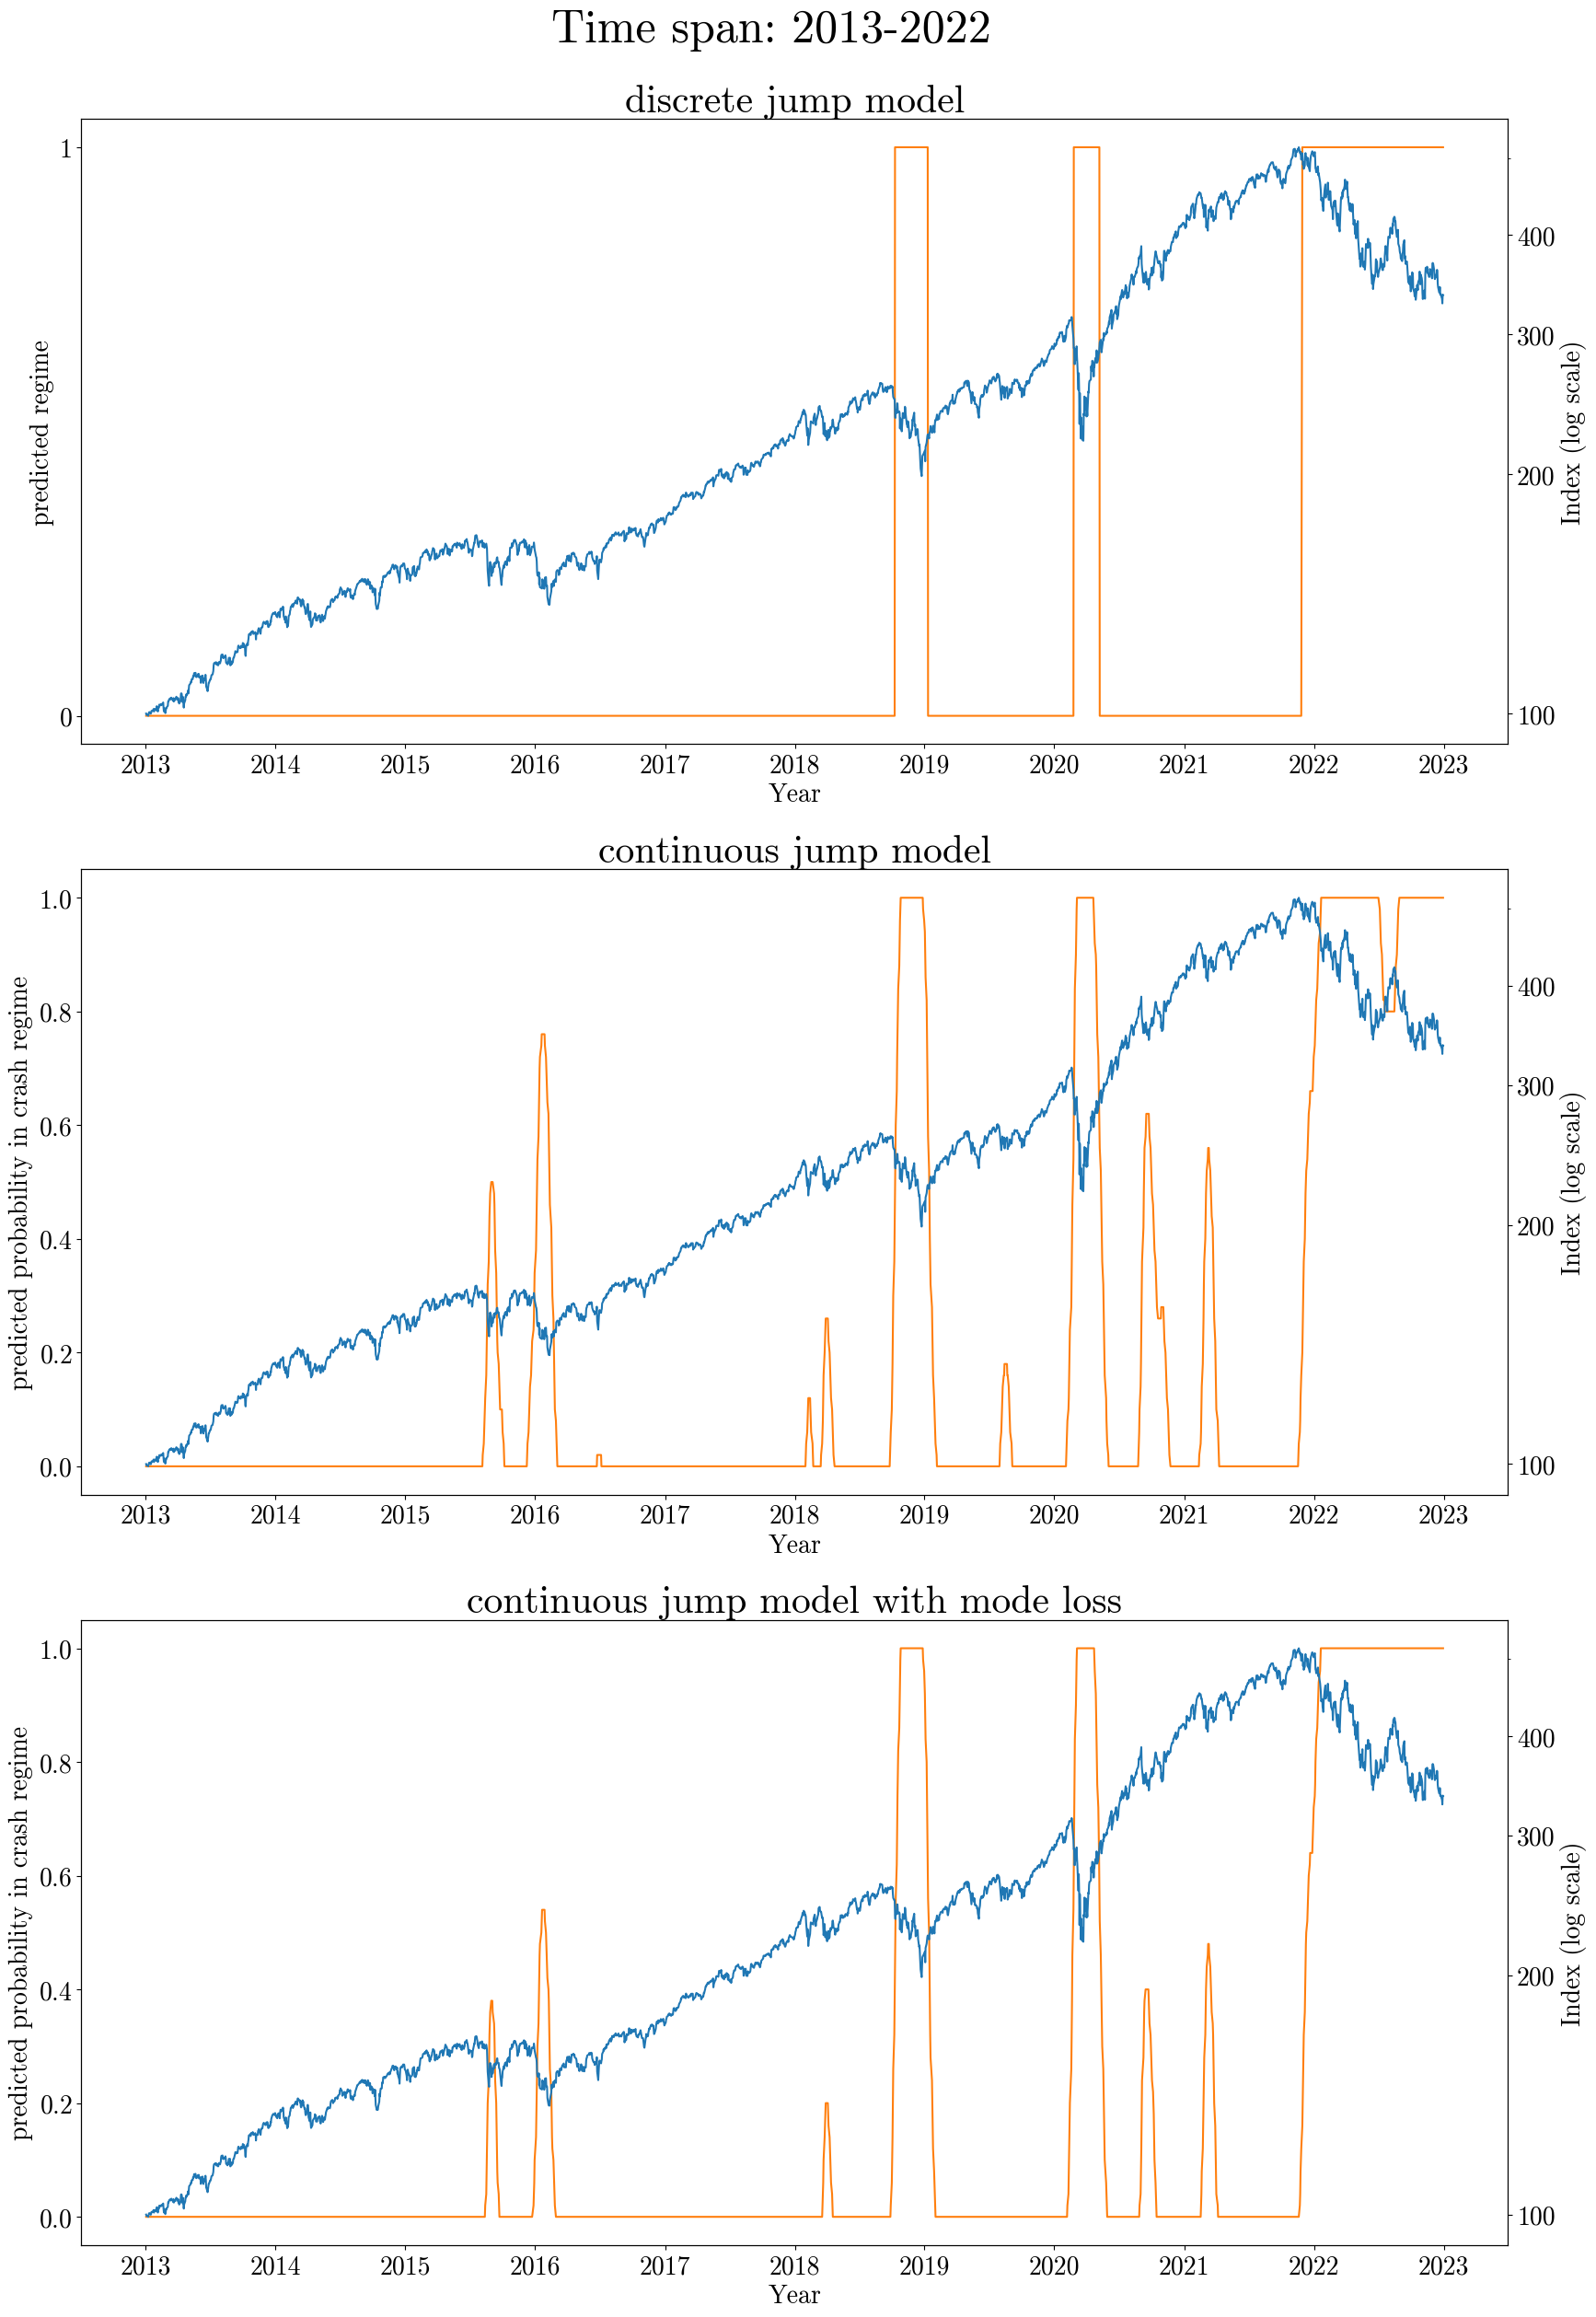

In [14]:
nrows = 3
_, ax = plt.subplots(nrows=nrows, figsize = (20, 10*nrows))

for ax_ in ax:
    # xlabel
    ax_.set(xlabel="Year")
    # index
    ax_y = ax_.twinx()
    ax_y.set(yscale="log", yticks=[1, 2, 3, 4], yticklabels=[100, 200, 300, 400], ylabel="Index (log scale)")
    _=(df_sub.CCMP/df_sub.CCMP.iloc[0]).plot(ax=ax_y, color = "C0")

# plot 0: regimes from discrete model
pd.Series(model["discrete"].labels_, index=X_zhengB.index).plot(ax=ax[0], color="C1")
ax[0].set(title="discrete jump model", yticks=[0., 1.], yticklabels=[0, 1], ylabel="predicted regime")

# plot 1: regimes from discrete model
pd.Series(model["cont"].proba_[:, 1], index=X_zhengB.index).plot(ax=ax[1], color="C1", ylabel="predicted probability in crash regime")
ax[1].set(title="continuous jump model")

# plot 2: regimes from discrete model
pd.Series(model['$\\text{cont}_{\\text{M}}$'].proba_[:, 1], index=X_zhengB.index).plot(ax=ax[2], color="C1", ylabel="predicted probability in crash regime")
ax[2].set(title="continuous jump model with mode loss")

plt.suptitle("Time span: 2013-2022", y=.92)
plt.savefig(f"{path['figure-paper']}/period-2013.jpeg", bbox_inches="tight", dpi=300)

## old version of plotting

In [15]:
# nrows = 4
# _, ax = plt.subplots(nrows=nrows, figsize = (20, 10*nrows))#, sharex=True
# for ax_ in ax:
#     ax_.set(xlabel="Year")

# # plot 0: index in log scale
# ax[0].set(yscale="log", yticks=[1, 2, 3, 4], yticklabels=[100, 200, 300, 400], ylabel="Index (log scale)")
# _=(df_sub.CCMP/df_sub.CCMP.iloc[0]).plot(ax=ax[0])
# ax[0].set(title="Nasdaq")


# # plot 1: regimes from discrete model
# pd.Series(model_discrete.labels_, index=X_zhengB.index).plot(ax=ax[1])
# ax[1].set(title="discrete jump model")
# # plot 2: regimes from discrete model
# pd.Series(model_cont.proba_[:, 1], index=X_zhengB.index).plot(ax=ax[2])
# ax[2].set(title="continuous jump model")

# # plot 3: regimes from discrete model
# pd.Series(model_cont_mode.proba_[:, 1], index=X_zhengB.index).plot(ax=ax[3])
# ax[3].set(title="continuous jump model with mode loss")

# plt.savefig(f"{path['figure-paper']}/Period-2.jpeg", bbox_inches="tight")

# sub period 1: 1996-2005

In [16]:
start, end = date(1996, 1, 1), date(2005, 12, 31)
df_sub = df.loc[get_trading_day_offset(start, -20):end]
X = df_sub[['CCMP_ret_log']].to_numpy()
X_zhengB = pd.DataFrame(feature_engineer_zheng(X), index=df_sub.index)[start:]
X_zhengB_np = X_zhengB.to_numpy()
df_sub = df_sub[start:]
X_zhengB

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1996-01-02,0.006178,0.003286,0.015118,0.002860,0.005540,0.002391,0.003585,0.003329,0.007952,-0.000192,0.012985,-0.004961,0.016311,0.004577,0.006799
1996-01-03,-0.011773,0.017950,0.003286,-0.000100,0.007813,-0.001490,0.004019,0.001290,0.011431,-0.000396,0.013154,-0.001561,0.017764,0.000769,0.007494
1996-01-04,-0.015838,0.004065,0.017950,-0.003134,0.009916,0.000876,0.007766,-0.007144,0.011715,-0.001830,0.013693,-0.001311,0.017871,-0.002349,0.009287
1996-01-05,0.003538,0.019376,0.004065,-0.002348,0.010282,0.003329,0.007952,-0.008024,0.010217,-0.000325,0.012975,0.001530,0.016383,-0.002181,0.009396
1996-01-08,-0.001065,0.004603,0.019376,-0.001583,0.010157,0.001290,0.011431,-0.004455,0.010123,0.000131,0.012816,0.002426,0.015977,-0.002164,0.009399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-23,0.001303,0.005320,0.002474,-0.000829,0.007048,-0.005682,0.006814,0.004025,0.002662,-0.000261,0.004836,0.000313,0.002915,-0.000834,0.006434
2005-12-27,-0.010066,0.011370,0.005320,-0.001904,0.007988,-0.003095,0.009087,-0.000713,0.008526,-0.001078,0.005464,-0.000008,0.002901,-0.002148,0.007320
2005-12-28,0.000920,0.010987,0.011370,0.000464,0.005722,0.003543,0.003424,-0.002614,0.006457,-0.000736,0.005425,0.000030,0.002843,-0.001501,0.007370
2005-12-29,-0.004848,0.005768,0.010987,-0.000320,0.006129,0.004025,0.002662,-0.004665,0.005496,-0.000906,0.005520,-0.001516,0.005816,-0.000295,0.005596


In [17]:
model, results = {}, {}

In [18]:
random_state = RandomState(10)
name = "discrete"
# discrete
model[name] = jump_model(2, state_type="discrete", jump_penalty=100.0, n_init=10, random_state=random_state)
x = fit_and_print_model(model[name], X_zhengB_np)
results[name] = cast_into_ser(x)
# empirical_trans_mx(model_discrete.labels_)

means: [ 0.001148   -0.00152831]
stds: [0.01215959 0.02687908]


In [19]:
# cont
name = "cont"
model[name] = jump_model(2, state_type="cont", jump_penalty=1000, grid_size=.02, mode_loss=False, n_init=10, random_state=random_state)
x = fit_and_print_model(model[name], X_zhengB_np)
results[name] = cast_into_ser(x)

means: [ 0.00102908 -0.00187853]
stds: [0.01289055 0.02861561]


In [20]:
# cont w/ mode loss
name = "$\\text{cont}_{\\text{M}}$"
model[name] = jump_model(2, state_type="cont", jump_penalty=1000, grid_size=.02, mode_loss=True, n_init=10, random_state=random_state)
x = fit_and_print_model(model[name], X_zhengB_np)
results[name] = cast_into_ser(x)

means: [ 0.00099493 -0.00174978]
stds: [0.01286228 0.02854937]


In [21]:
results_df = pd.DataFrame(results).T
results_df = results_df.applymap(lambda x: f"{100*x:.4f}\\%")
results_df

,$\mu_0$,$\mu_1$,$\sigma_0$,$\sigma_1$,$\gamma_{01}$,$\gamma_{10}$
discrete,0.1148\%,-0.1528\%,1.2160\%,2.6879\%,0.1167\%,0.2488\%
cont,0.1029\%,-0.1879\%,1.2891\%,2.8616\%,0.2129\%,0.6260\%
$\text{cont}_{\text{M}}$,0.0995\%,-0.1750\%,1.2862\%,2.8549\%,0.2133\%,0.6221\%


In [25]:
print(results_df.style.to_latex(hrules=True, label="tab: parameters 1996", caption="1996-2005", position_float="centering", position="htbp"))

\begin{table}[htbp]
\centering
\caption{1996-2005}
\label{tab: parameters 1996}
\begin{tabular}{lllllll}
\toprule
 & $\mu_0$ & $\mu_1$ & $\sigma_0$ & $\sigma_1$ & $\gamma_{01}$ & $\gamma_{10}$ \\
\midrule
discrete & 0.1148\% & -0.1528\% & 1.2160\% & 2.6879\% & 0.1167\% & 0.2488\% \\
cont & 0.1029\% & -0.1879\% & 1.2891\% & 2.8616\% & 0.2129\% & 0.6260\% \\
$\text{cont}_{\text{M}}$ & 0.0995\% & -0.1750\% & 1.2862\% & 2.8549\% & 0.2133\% & 0.6221\% \\
\bottomrule
\end{tabular}
\end{table}



## plotting

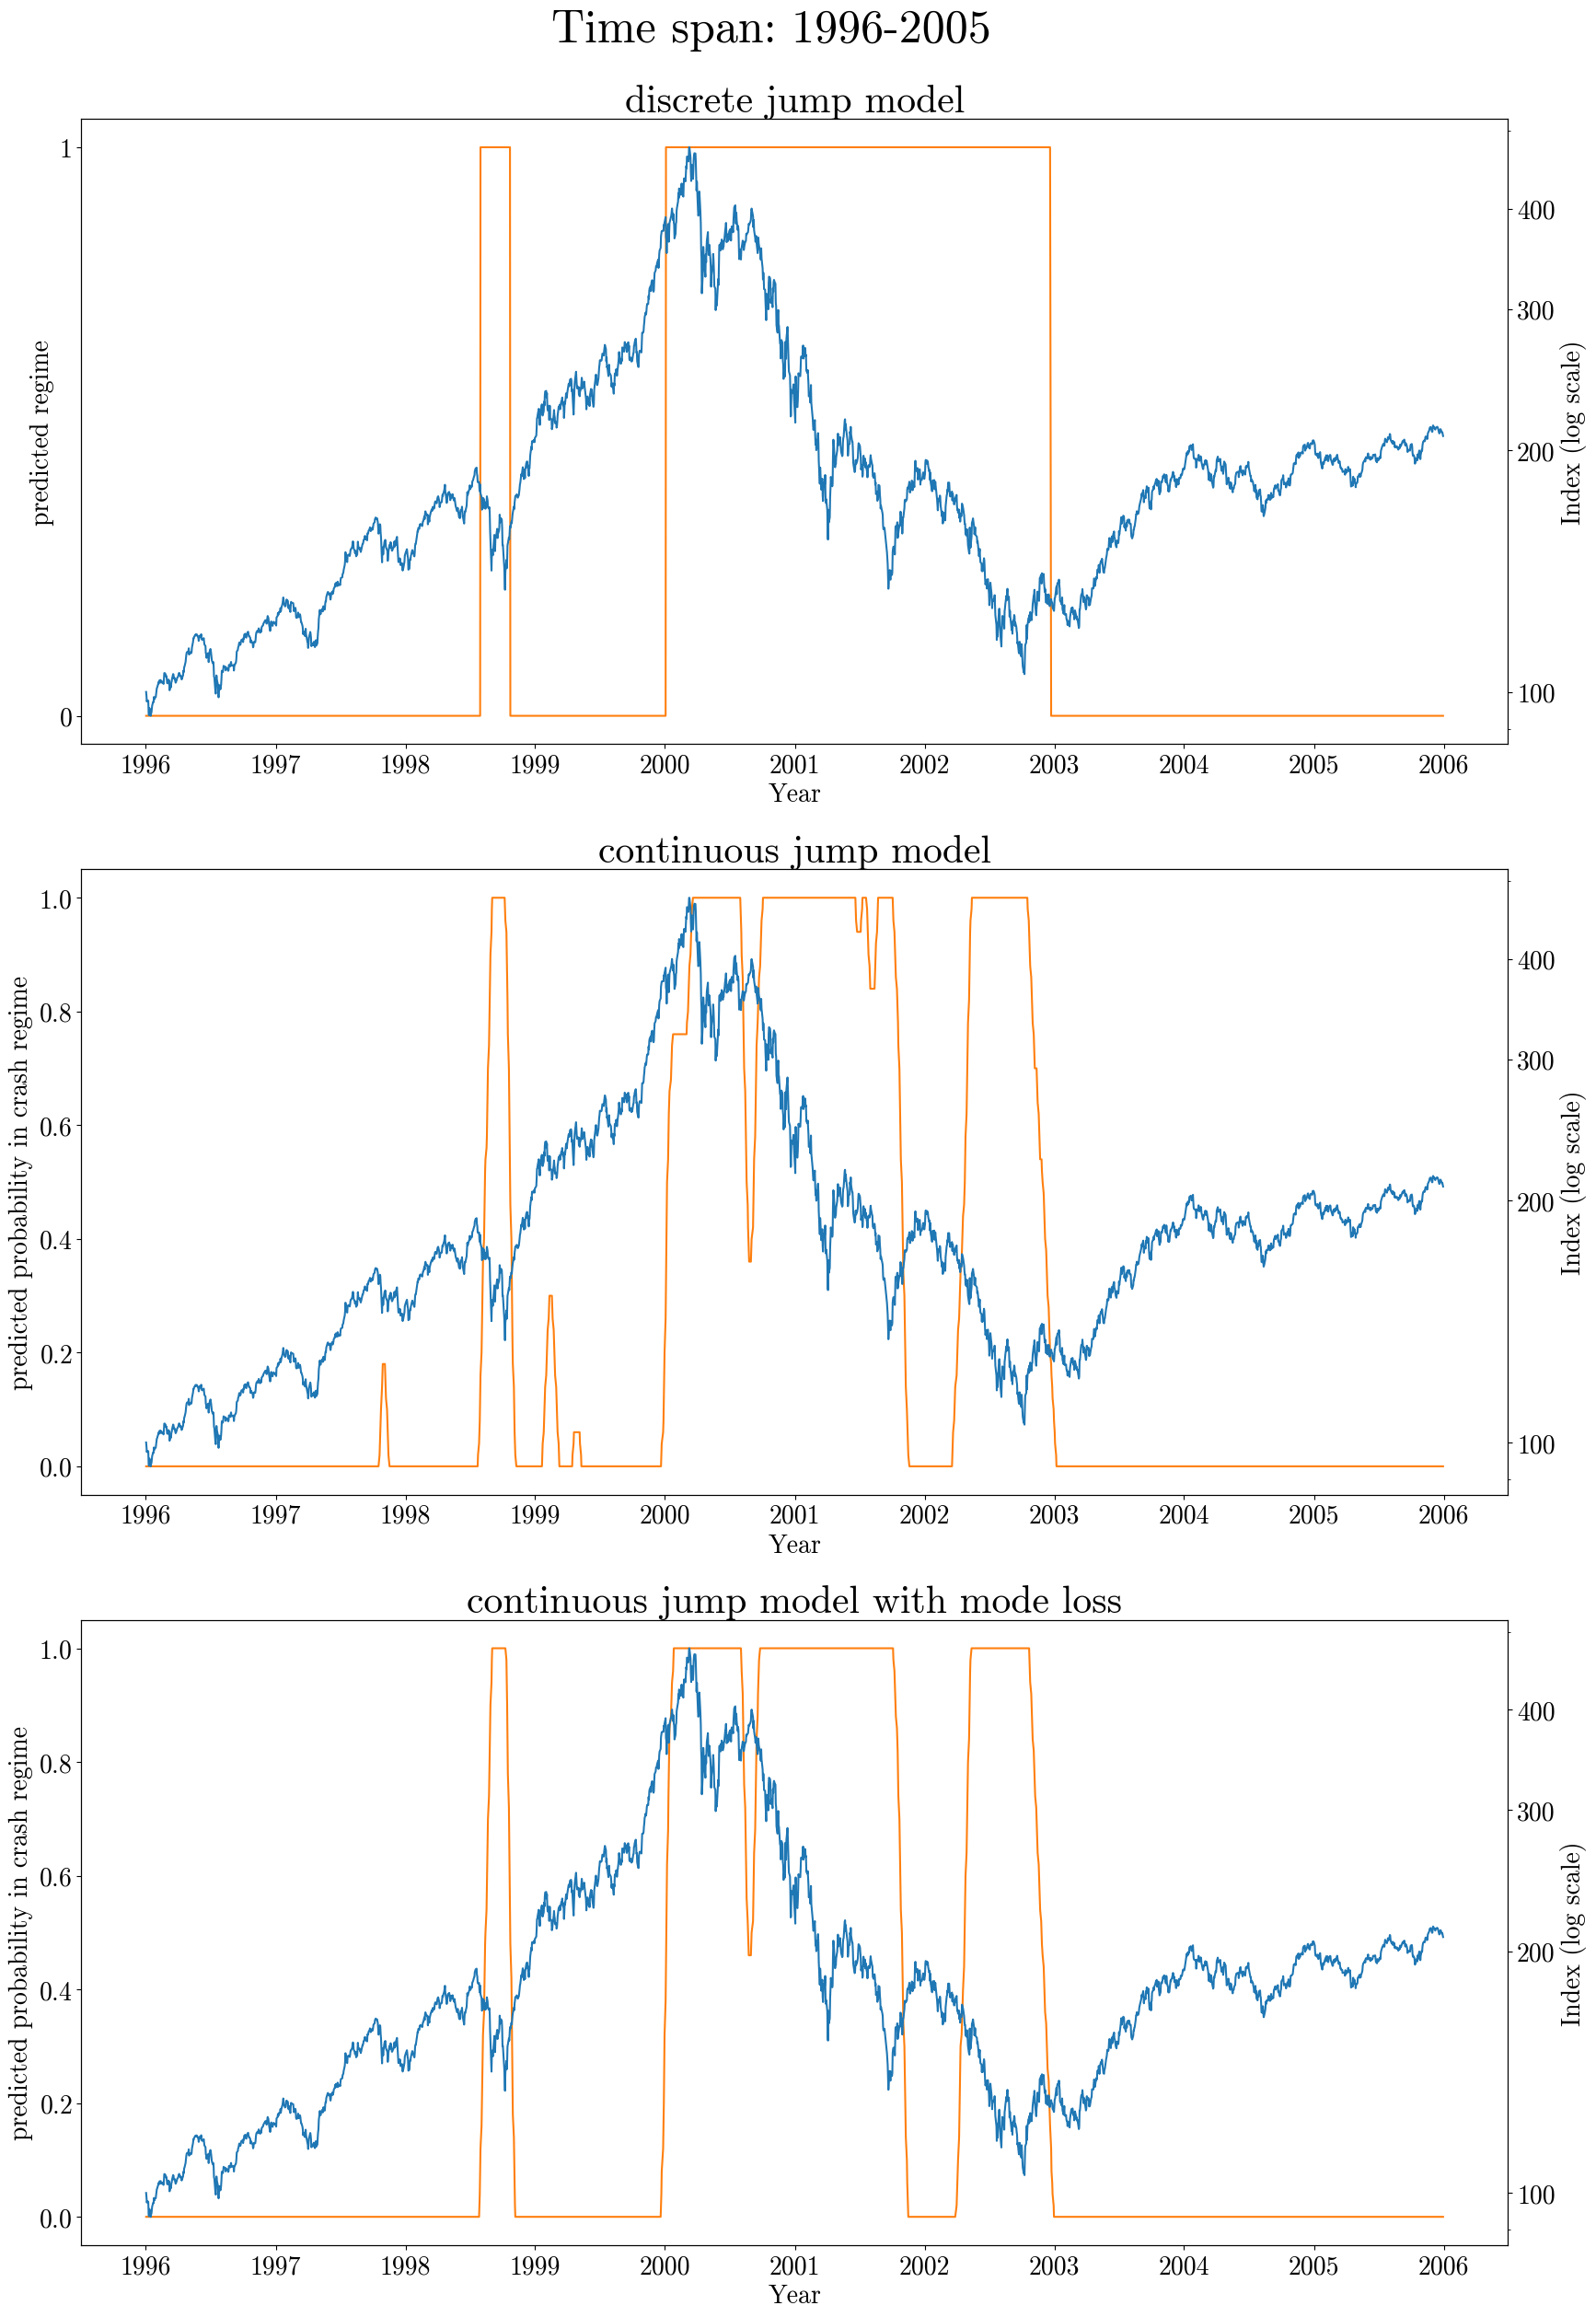

In [23]:
nrows = 3
_, ax = plt.subplots(nrows=nrows, figsize = (20, 10*nrows))

for ax_ in ax:
    # xlabel
    ax_.set(xlabel="Year")
    # index
    ax_y = ax_.twinx()
    ax_y.set(yscale="log", yticks=[1, 2, 3, 4], yticklabels=[100, 200, 300, 400], ylabel="Index (log scale)")
    _=(df_sub.CCMP/df_sub.CCMP.iloc[0]).plot(ax=ax_y, color = "C0")

# plot 0: regimes from discrete model
pd.Series(model["discrete"].labels_, index=X_zhengB.index).plot(ax=ax[0], color="C1")
ax[0].set(title="discrete jump model", yticks=[0., 1.], yticklabels=[0, 1], ylabel="predicted regime")

# plot 1: regimes from discrete model
pd.Series(model["cont"].proba_[:, 1], index=X_zhengB.index).plot(ax=ax[1], color="C1", ylabel="predicted probability in crash regime")
ax[1].set(title="continuous jump model")

# plot 2: regimes from discrete model
pd.Series(model['$\\text{cont}_{\\text{M}}$'].proba_[:, 1], index=X_zhengB.index).plot(ax=ax[2], color="C1", ylabel="predicted probability in crash regime")
ax[2].set(title="continuous jump model with mode loss")

plt.suptitle("Time span: 1996-2005", y=.92)
plt.savefig(f"{path['figure-paper']}/period-1996.jpeg", bbox_inches="tight", dpi=300)

## plotting - old version

In [24]:
# nrows = 4
# _, ax = plt.subplots(nrows=nrows, figsize = (20, 10*nrows))#, sharex=True
# for ax_ in ax:
#     ax_.set(xlabel="Year")

# # plot 0: index in log scale
# ax[0].set(yscale="log", yticks=[1, 2, 3, 4], yticklabels=[100, 200, 300, 400], ylabel="Index (log scale)")
# _=(df_sub.CCMP/df_sub.CCMP.iloc[0]).plot(ax=ax[0])
# ax[0].set(title="Nasdaq")


# # plot 1: regimes from discrete model
# pd.Series(model_discrete.labels_, index=X_zhengB.index).plot(ax=ax[1])
# ax[1].set(title="discrete jump model")
# # plot 2: regimes from discrete model
# pd.Series(model_cont.proba_[:, 1], index=X_zhengB.index).plot(ax=ax[2])
# ax[2].set(title="continuous jump model")

# # plot 3: regimes from discrete model
# pd.Series(model_cont_mode.proba_[:, 1], index=X_zhengB.index).plot(ax=ax[3])
# ax[3].set(title="continuous jump model with mode loss")

# plt.savefig(f"{path['figure-paper']}/Period-1.jpeg", bbox_inches="tight")

## three-state models

In [36]:
random_state = RandomState(10)
# discrete
model_discrete_three = jump_model(3, state_type="discrete", jump_penalty=100.0, n_init=100, random_state=random_state)
fit_and_print_model(model_discrete_three, X_zhengB_np)
# empirical_trans_mx(model_discrete.labels_)

means: [ 0.00067864  0.00036825 -0.00280725]
stds: [0.010739   0.0202337  0.03843162]


In [37]:
# cont
model_cont_three = jump_model(3, state_type="cont", jump_penalty=2000, grid_size=.05, mode_loss=False, n_init=100, random_state=random_state)
fit_and_print_model(model_cont_three, X_zhengB_np)

means: [ 0.00074318  0.00051469 -0.00390596]
stds: [0.01059707 0.02050129 0.03727938]


In [38]:
# cont w/ mode loss
model_cont_mode_three = jump_model(3, state_type="cont", jump_penalty=2000, grid_size=.05, mode_loss=True, n_init=100, random_state=random_state)
fit_and_print_model(model_cont_mode_three, X_zhengB_np)

means: [ 0.00073993  0.00051896 -0.00390596]
stds: [0.01060278 0.02050304 0.03727938]


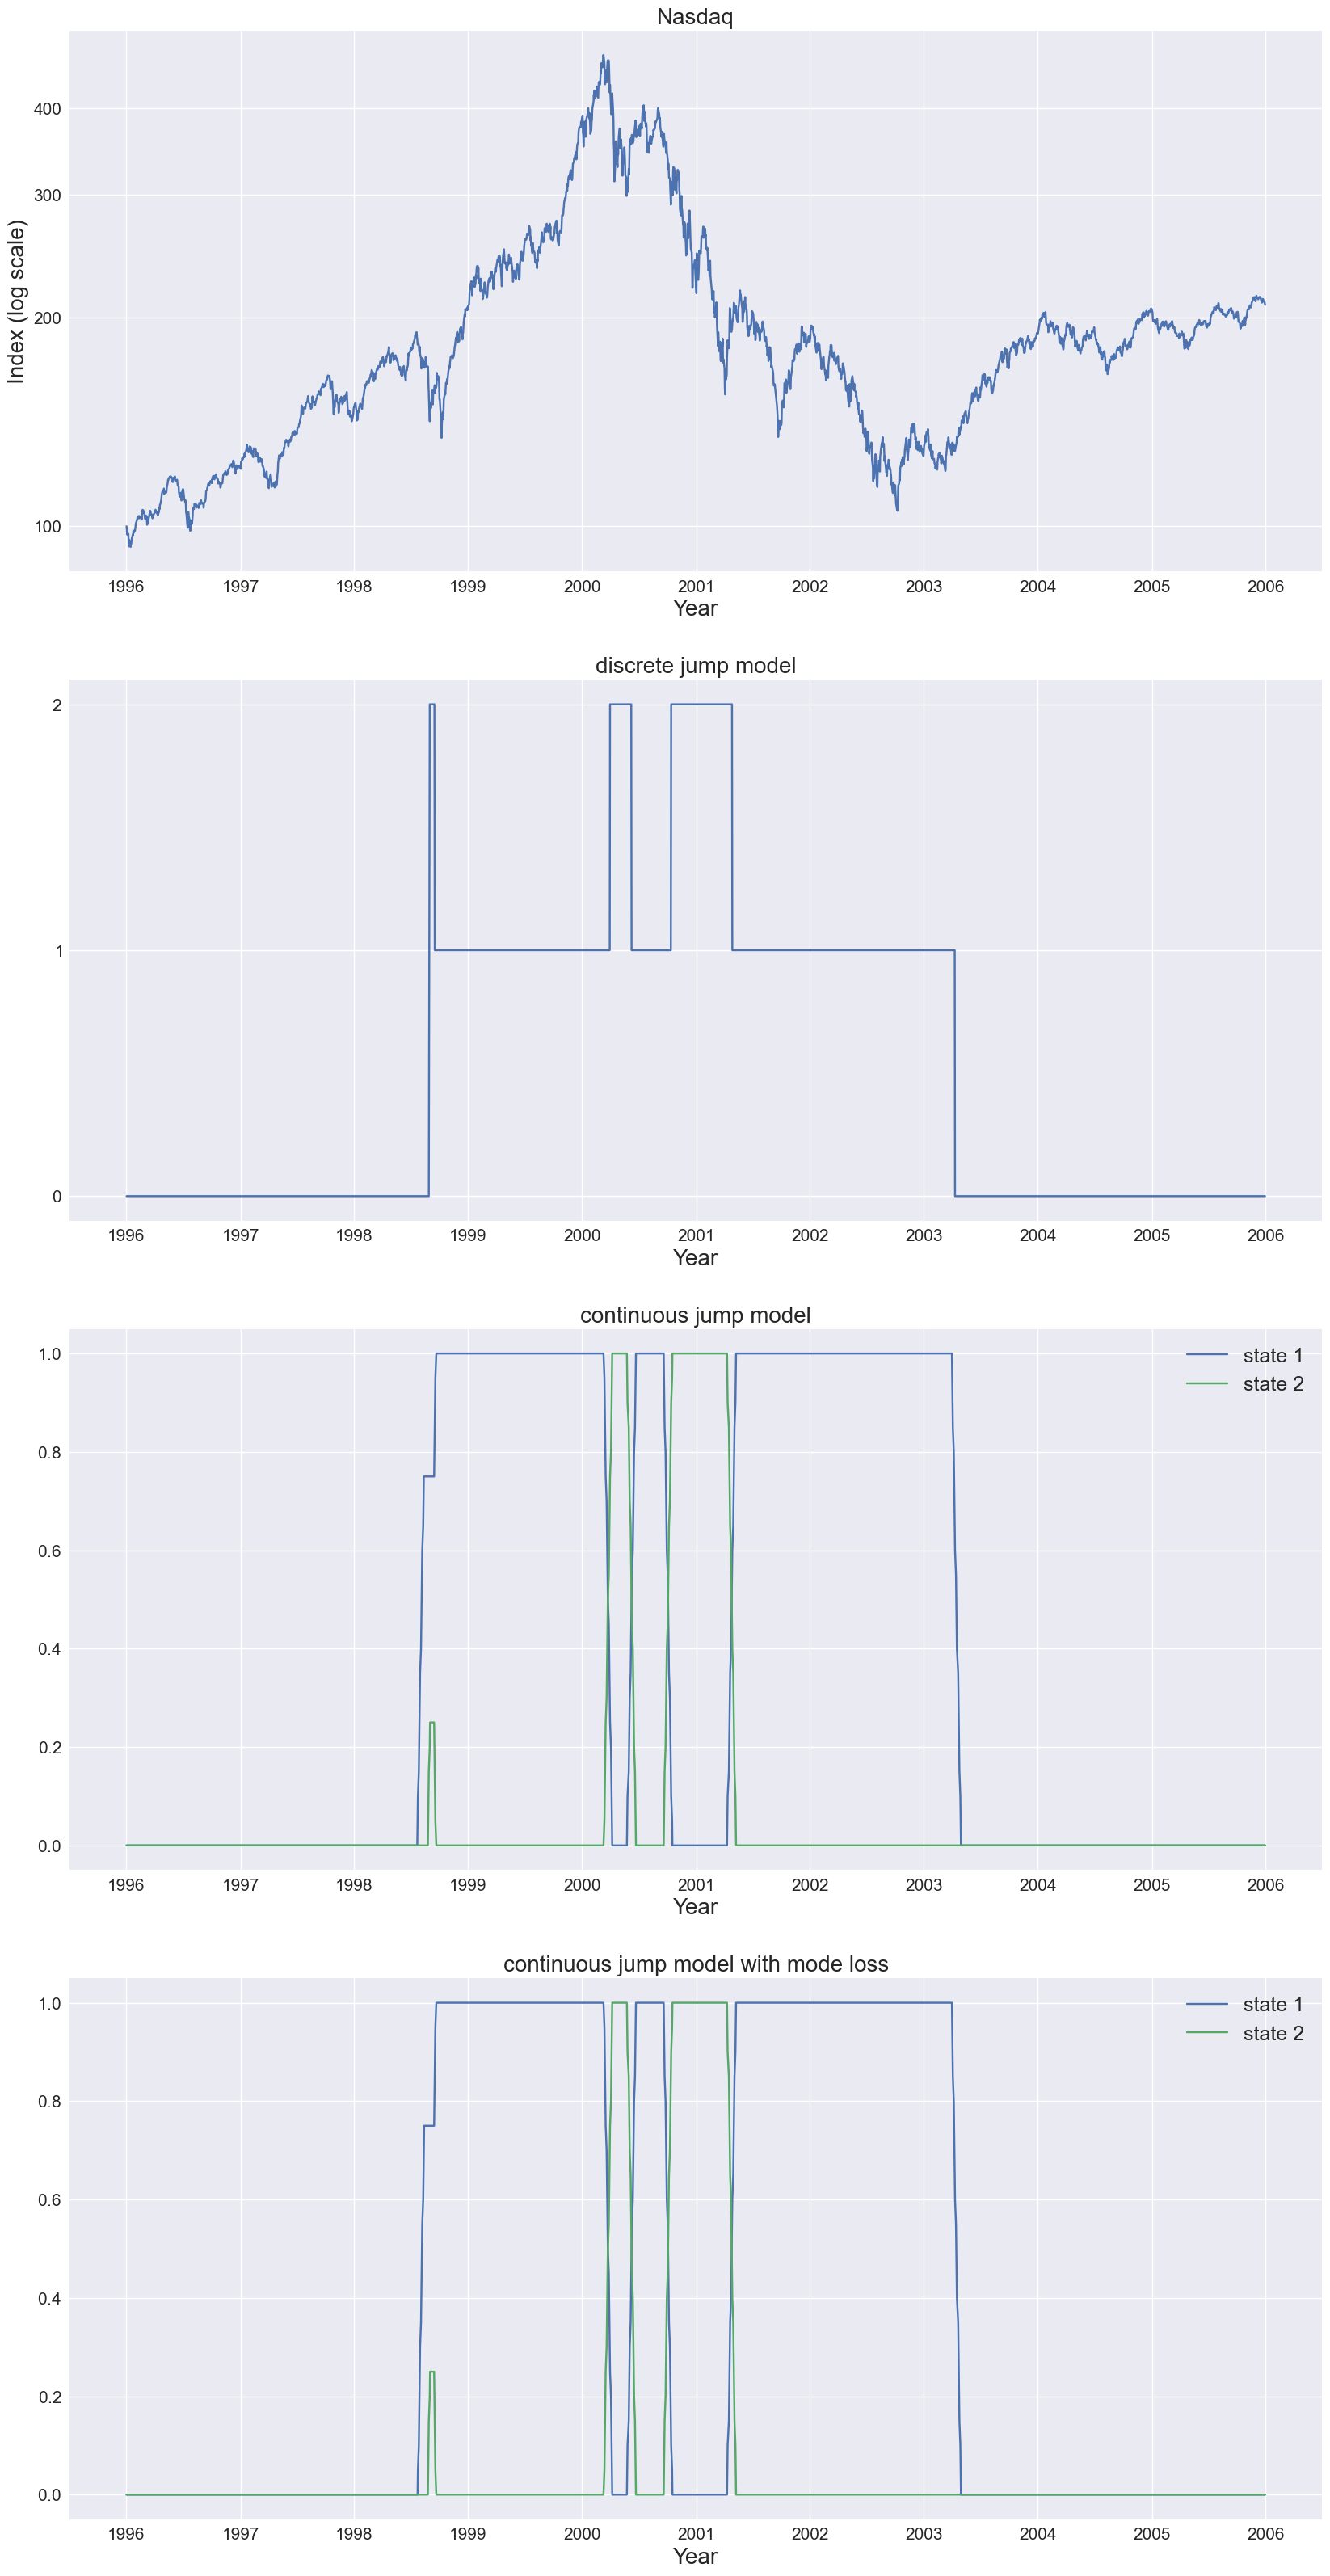

In [39]:
nrows = 4
_, ax = plt.subplots(nrows=nrows, figsize = (20, 10*nrows))#, sharex=True
for ax_ in ax:
    ax_.set(xlabel="Year")

# plot 0: index in log scale
ax[0].set(yscale="log", yticks=[1, 2, 3, 4], yticklabels=[100, 200, 300, 400], ylabel="Index (log scale)")
_=(df_sub.CCMP/df_sub.CCMP.iloc[0]).plot(ax=ax[0])
ax[0].set(title="Nasdaq")


# plot 1: regimes from discrete model
pd.Series(model_discrete_three.labels_, index=X_zhengB.index).plot(ax=ax[1])
_=ax[1].set(title="discrete jump model", yticks=[0, 1, 2])#, yticklabels=[1, 2, 3])

# plot 2: regimes from discrete model
pd.Series(model_cont_three.proba_[:, 1], index=X_zhengB.index).plot(ax=ax[2], label="state 1")
pd.Series(model_cont_three.proba_[:, 2], index=X_zhengB.index).plot(ax=ax[2], label="state 2")
ax[2].legend()
ax[2].set(title="continuous jump model")


# plot 3: regimes from discrete model
pd.Series(model_cont_mode_three.proba_[:, 1], index=X_zhengB.index).plot(ax=ax[3], label="state 1")
pd.Series(model_cont_mode_three.proba_[:, 2], index=X_zhengB.index).plot(ax=ax[3], label="state 2")
ax[3].legend()
ax[3].set(title="continuous jump model with mode loss")

plt.savefig(f"{path['figure-paper']}/Period-1-three-state.jpeg", bbox_inches="tight")

[Text(0.5, 1.0, 'continuous jump model with mode loss')]

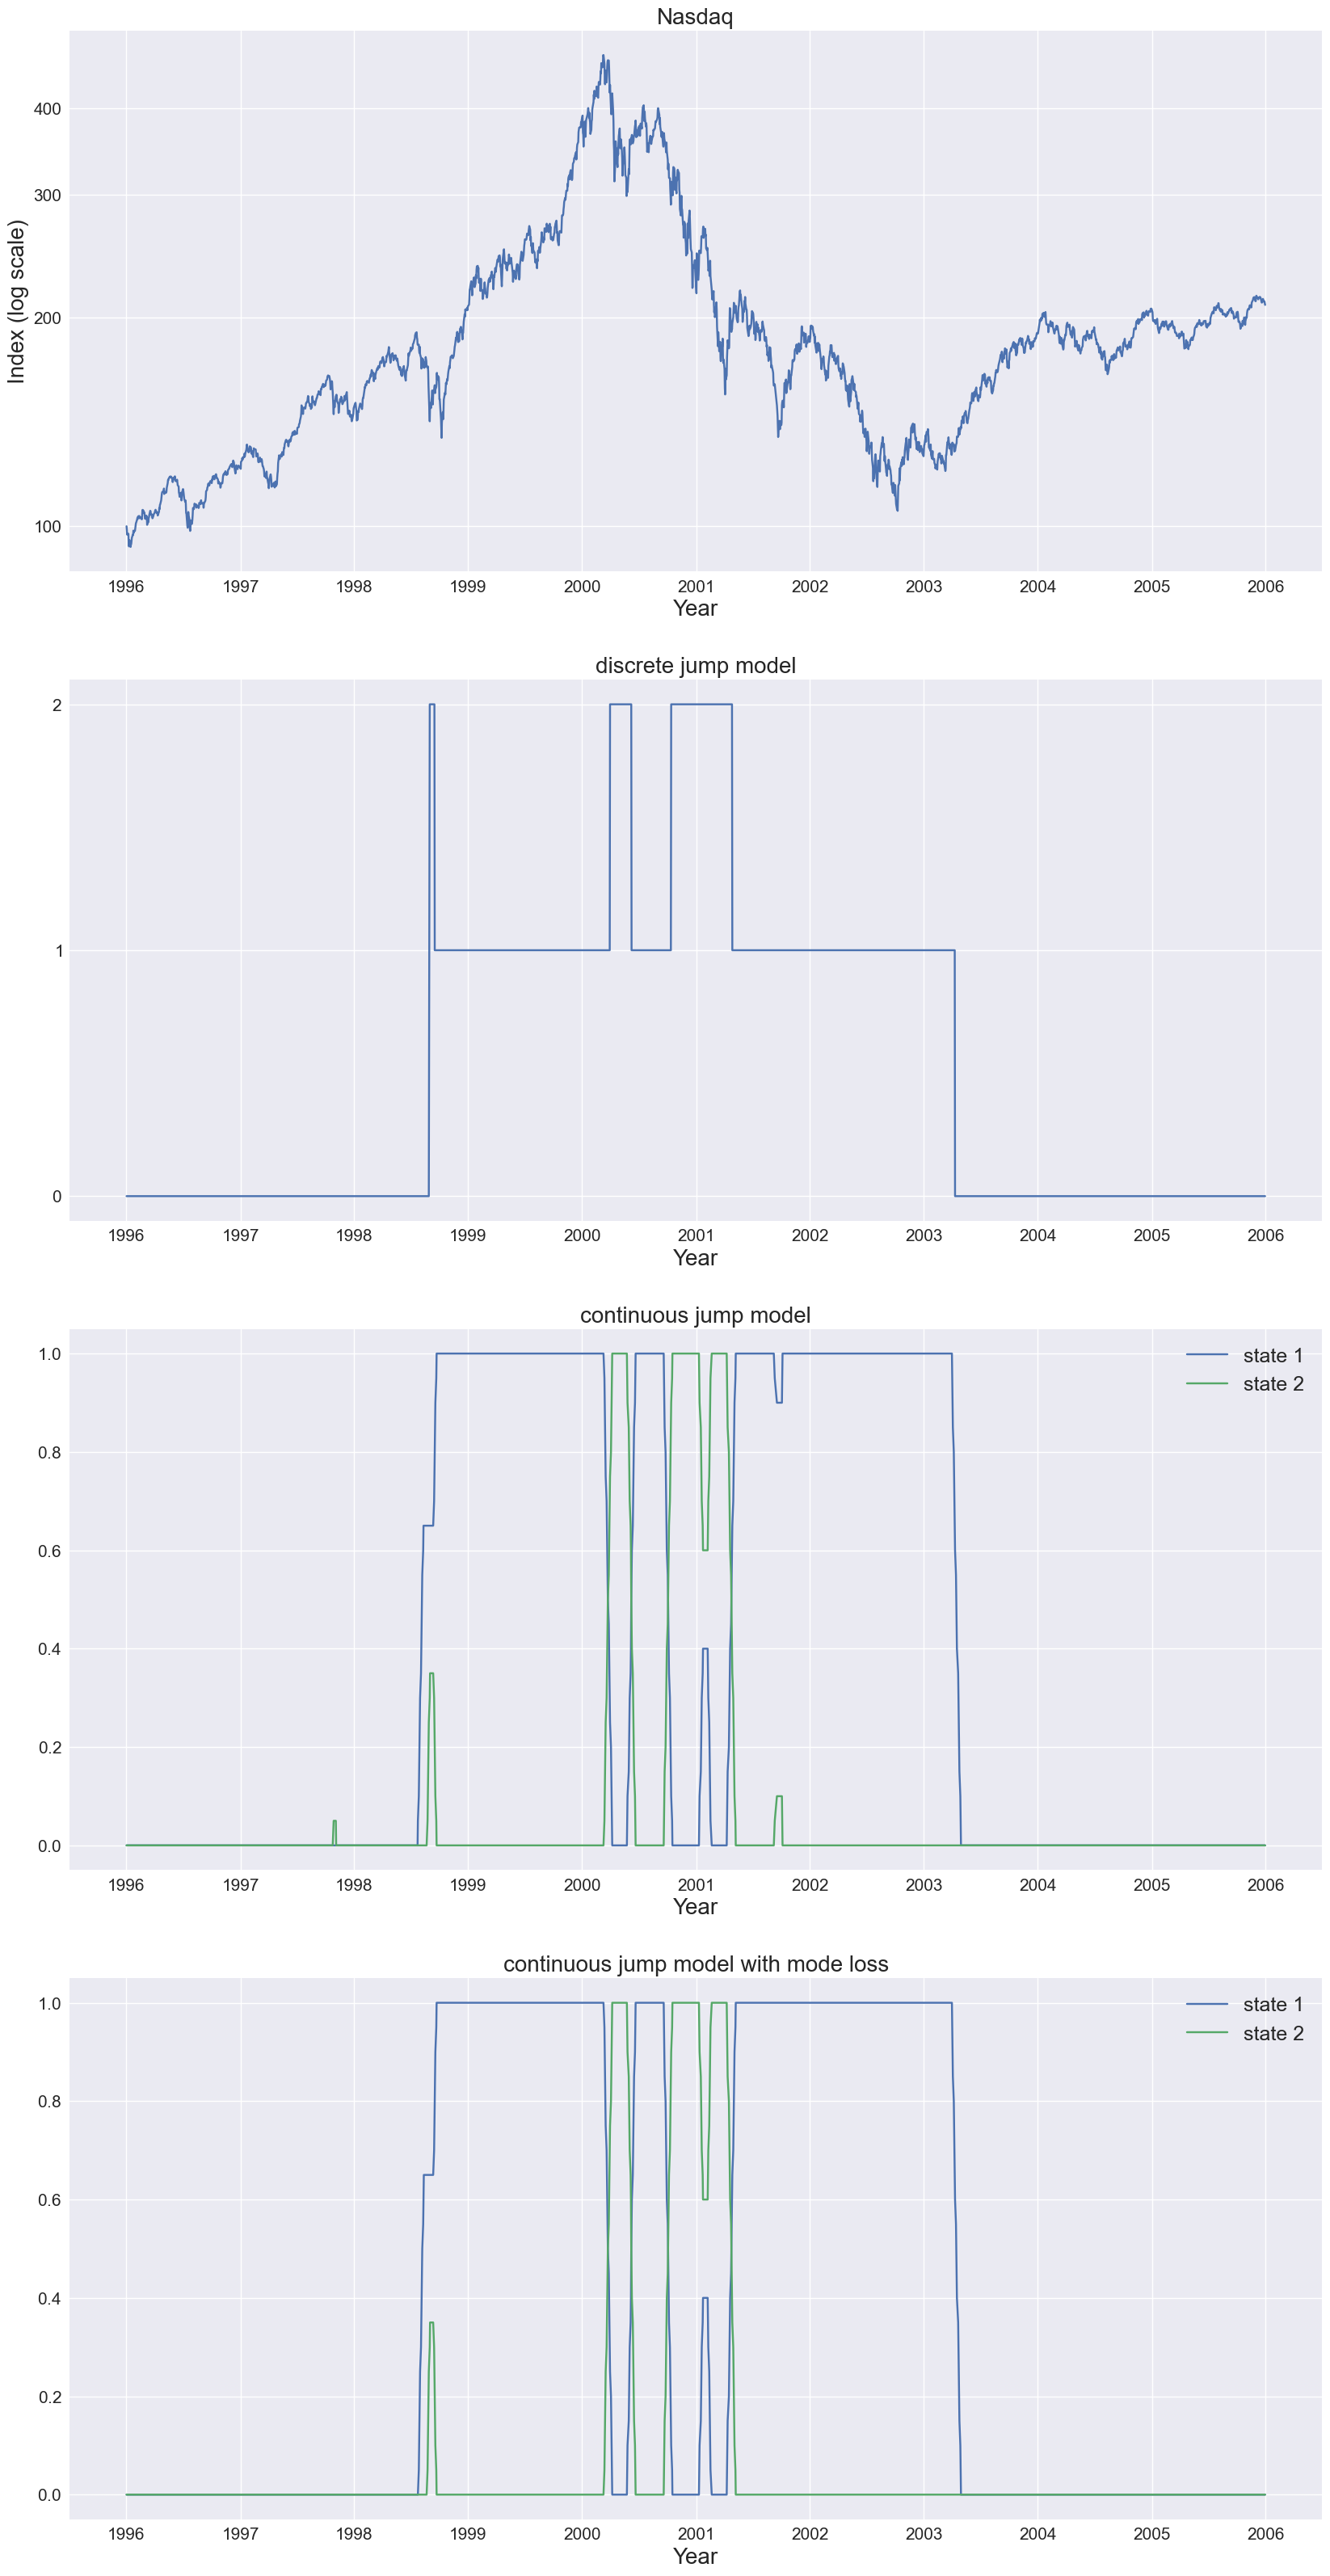

In [33]:
nrows = 4
_, ax = plt.subplots(nrows=nrows, figsize = (20, 10*nrows))#, sharex=True
for ax_ in ax:
    ax_.set(xlabel="Year")

# plot 0: index in log scale
ax[0].set(yscale="log", yticks=[1, 2, 3, 4], yticklabels=[100, 200, 300, 400], ylabel="Index (log scale)")
_=(df_sub.CCMP/df_sub.CCMP.iloc[0]).plot(ax=ax[0])
ax[0].set(title="Nasdaq")


# plot 1: regimes from discrete model
pd.Series(model_discrete_three.labels_, index=X_zhengB.index).plot(ax=ax[1])
_=ax[1].set(title="discrete jump model", yticks=[0, 1, 2])#, yticklabels=[1, 2, 3])

# plot 2: regimes from discrete model
pd.Series(model_cont_three.proba_[:, 1], index=X_zhengB.index).plot(ax=ax[2], label="state 1")
pd.Series(model_cont_three.proba_[:, 2], index=X_zhengB.index).plot(ax=ax[2], label="state 2")
ax[2].legend()
ax[2].set(title="continuous jump model")


# plot 3: regimes from discrete model
pd.Series(model_cont_mode_three.proba_[:, 1], index=X_zhengB.index).plot(ax=ax[3], label="state 1")
pd.Series(model_cont_mode_three.proba_[:, 2], index=X_zhengB.index).plot(ax=ax[3], label="state 2")
ax[3].legend()
ax[3].set(title="continuous jump model with mode loss")

# plt.savefig(f"{path['figure-paper']}/Period 1.jpeg", bbox_inches="tight")